In [1]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Query the transaction data
query_transactions = "SELECT timestamp, input_addresses_x, output_addresses_y, input_amounts_x, output_amounts_y FROM Transactions"
transactions_df = pd.read_sql_query(query_transactions, conn)

# Close the database connection
conn.close()


In [2]:
import ast

# Initialize balances for all addresses to zero
address_balances = {}

# Function to process transactions and update balances
def process_transactions(transactions):
    for _, tx in transactions.iterrows():
        input_addresses = ast.literal_eval(tx['input_addresses_x'])
        output_addresses = ast.literal_eval(tx['output_addresses_y'])
        input_amounts = ast.literal_eval(tx['input_amounts_x'])
        output_amounts = ast.literal_eval(tx['output_amounts_y'])

        for addr, amount in zip(input_addresses, input_amounts):
            if addr in address_balances:
                address_balances[addr] -= amount
            else:
                address_balances[addr] = -amount

        for addr, amount in zip(output_addresses, output_amounts):
            if addr in address_balances:
                address_balances[addr] += amount
            else:
                address_balances[addr] = amount

# Process the transactions
process_transactions(transactions_df)

# Convert the address balances to a DataFrame
balances_df = pd.DataFrame(list(address_balances.items()), columns=['address', 'balance'])
balances_df = balances_df[balances_df['balance'] > 0]  # Filter out addresses with zero or negative balance

# Add a timestamp column based on the transaction data
balances_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'].max())

In [3]:
balances_df.to_csv("address_balance_model.csv", index=False)

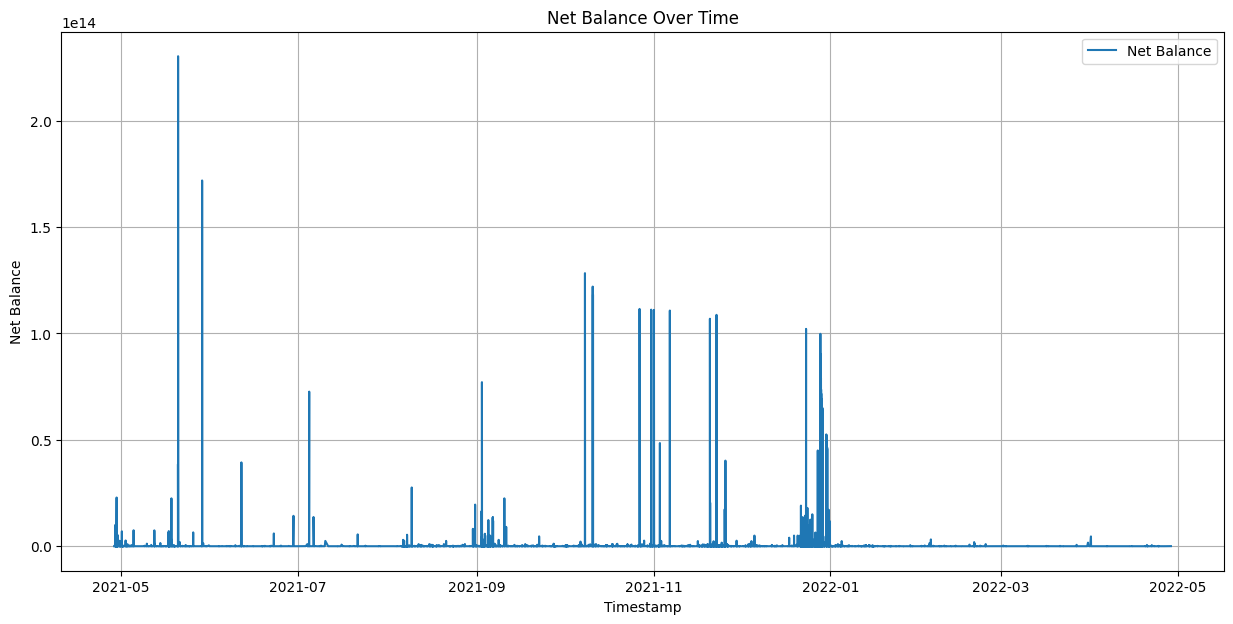

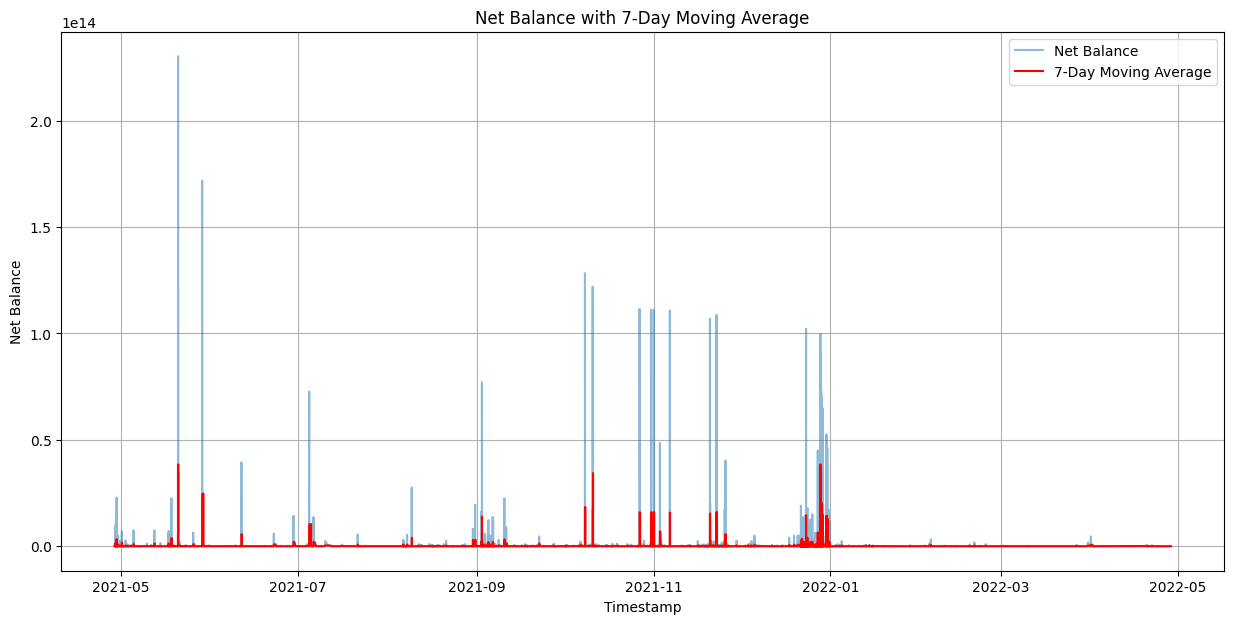

In [7]:
import matplotlib.pyplot as plt
# Calculate net balance changes over time
transactions_df['net_input'] = transactions_df['input_amounts_x'].apply(lambda x: sum(ast.literal_eval(x)))
transactions_df['net_output'] = transactions_df['output_amounts_y'].apply(lambda x: sum(ast.literal_eval(x)))
transactions_df['net_balance'] = transactions_df['net_output'] - transactions_df['net_input']

# Group by timestamp and aggregate the net balances
transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
time_series = transactions_df.groupby('timestamp')['net_balance'].sum().reset_index()

# Filter positive net balances
time_series = time_series[time_series['net_balance'] > 0]

# Plotting the time series data
plt.figure(figsize=(15, 7))
plt.plot(time_series['timestamp'], time_series['net_balance'], label='Net Balance')
plt.xlabel('Timestamp')
plt.ylabel('Net Balance')
plt.title('Net Balance Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Applying moving average to smooth out the data
time_series['moving_average'] = time_series['net_balance'].rolling(window=7).mean()

# Plotting the moving average
plt.figure(figsize=(15, 7))
plt.plot(time_series['timestamp'], time_series['net_balance'], label='Net Balance', alpha=0.5)
plt.plot(time_series['timestamp'], time_series['moving_average'], label='7-Day Moving Average', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Net Balance')
plt.title('Net Balance with 7-Day Moving Average')
plt.legend()
plt.grid(True)
plt.show()